In [17]:
%reload_ext autoreload
%autoreload 2
%load_ext jupyter_black

import unicodedata
import re
import random
from pathlib import Path

import sys

sys.path.append("..")

from src.datautil import *
from src.modelutil import *
from src.trainutil import *
from src.metrics import *

import yaml

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


# File Processing

In [18]:
def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn"
    )


# Lowercase, trim, and remove non-letter characters
def normalize(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [19]:
MAX_LINES = 10000
data = Path("../data")
train_eng = open(data / "train.eng", "w")
train_fra = open(data / "train.fra", "w")

dev_eng = open(data / "dev.eng", "w")
dev_fra = open(data / "dev.fra", "w")

with open(data / "eng-fra.txt", "r") as file:
    i = 0
    for line in file:
        eng, fra = line.split("\t")
        eng = normalize(eng)
        fra = normalize(fra)
        is_dev = True if random.random() < 0.3 else False

        if is_dev:
            dev_eng.write(eng.strip() + "\n")
            dev_fra.write(fra.strip() + "\n")
        else:
            train_eng.write(eng.strip() + "\n")
            train_fra.write(fra.strip() + "\n")

        i += 1
        if i == MAX_LINES:
            break


train_eng.close()
train_fra.close()
dev_eng.close()
dev_fra.close()

# Load Data

In [48]:
with open("../config.yaml", "r") as stream:
    cfg = yaml.safe_load(stream)

In [20]:
data_root = "../data"
train_src_path = f"{data_root}/train.{cfg['src']}"
train_tgt_path = f"{data_root}/train.{cfg['tgt']}"

src_vocab, tgt_vocab = load_and_build_vocab(
    sentence_path=train_src_path,
    question_path=train_tgt_path,
    src_vocab_size=cfg["src_vocab_size"],
    tgt_vocab_size=cfg["tgt_vocab_size"],
)

print(len(src_vocab), len(tgt_vocab))

3286 1938


In [26]:
train_ds = SourceTargetDataset(
    data_dir=data_root,
    srcfile=data_root + f"/train.{cfg['src']}",
    tgtfile=data_root + f"/train.{cfg['tgt']}",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    src_max_seq=cfg["src_max_seq"],
    tgt_max_seq=cfg["tgt_max_seq"],
    return_tokenizers=True,
)

src_tokenizer = train_ds.src_tokenizer
tgt_tokenizer = train_ds.tgt_tokenizer

dev_ds = SourceTargetDataset(
    data_dir=data_root,
    srcfile=data_root + f"/dev.{cfg['src']}",
    tgtfile=data_root + f"/dev.{cfg['tgt']}",
    src_vocab=src_vocab,
    tgt_vocab=tgt_vocab,
    src_max_seq=cfg["src_max_seq"],
    tgt_max_seq=cfg["tgt_max_seq"],
)

In [28]:
print(len(train_ds), len(dev_ds))
train_ds[0]

6966 3034


(tensor([61,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2]),
 tensor([22,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]),
 tensor([ True,  True, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([ True,  True, False, False, False, False, False, False, False, False,
         False, False]))

In [29]:
train_dl = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True)
valid_dl = DataLoader(dev_ds, batch_size=cfg["batch_size"], shuffle=False)

In [79]:
def save_history(history, history_dir, save_graph=True):
    if not os.path.exists(history_dir):
        os.makedirs(history_dir)

    with open(f"{history_dir}/history.json", "w") as f:
        json.dump(history, f)

    if save_graph:
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(history["train/loss"], label="train/loss")
        ax.plot(history["valid/loss"], label="valid/loss")
        ax.legend()
        plt.savefig(f"{history_dir}/history_loss.png")

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.plot(history["valid/pplx"], label="valid/pplx")
        ax.legend()
        plt.savefig(f"{history_dir}/history_pplx.png")


def plot_attention(attention, src, tgt):
    """
    attention: (S, T)
    src: str
    tgt: str
    """
    src = src.split()
    tgt = tgt.split()

    # ignores pad tokens, this won't work with sub-word tokenization
    attention = attention[: len(src), : len(tgt)]

    fig, ax = plt.subplots(figsize=(20, 8))
    # tgt on y axis, src on x-axis
    heatmap = ax.pcolor(attention.T.cpu(), cmap=plt.cm.Blues, alpha=0.9)

    xticks = range(0, len(src))
    ax.set_xticks(xticks, minor=False)  # major ticks
    ax.set_xticklabels(src, minor=False, rotation=45)  # labels should be 'unicode'

    yticks = range(0, len(tgt))
    ax.set_yticks(yticks, minor=False)
    ax.set_yticklabels(tgt, minor=False)  # labels should be 'unicode'

    ax.set_xlabel("source")
    ax.set_ylabel("target")

    ax.grid(False)

    # Save Figure
    plt.show()
    fig.savefig("attention.png")

In [49]:
def get_optimizer(model, cfg):
    if cfg["optim"] == "adam":
        return torch.optim.Adam(
            model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"]
        )
    elif cfg["optim"] == "sgd":
        return torch.optim.SGD(
            model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"]
        )

In [73]:
cfg["experiment_name"] = "debug1"
checkpoint_dir = f"{cfg['checkpoint_dir']}/{cfg['experiment_name']}"
history_dir = f"{checkpoint_dir}/history"
cfg["max_epoch"] = 150
cfg["lr"] = 4e-4

print("Training Parameters:", cfg)

model = Seq2Seq(
    src_vocab_size=len(src_vocab),
    tgt_vocab_size=len(tgt_vocab),
    src_embedding_vector=None,
    tgt_embedding_vector=None,
    tgt_pad_index=tgt_vocab["<PAD>"],
    tgt_sos_index=tgt_vocab["<SOS>"],
    tgt_eos_index=tgt_vocab["<EOS>"],
    hidden_size=cfg["hidden_size"],
    bidirectional=cfg["bidirectional"],
    num_layers=cfg["num_layers"],
    src_embedding_size=cfg["src_embedding_size"],
    tgt_embedding_size=cfg["tgt_embedding_size"],
    dropout=cfg["dropout"],
)

optimizer = get_optimizer(model, cfg)


history = fit(
    model=model,
    optimizer=optimizer,
    train_dl=train_dl,
    valid_dl=valid_dl,
    cfg=cfg,
    checkpoint_dir=checkpoint_dir,
    max_step=-1,
    epoch=0,
    lr_scheduler=None,
    ignore_index=tgt_vocab["<PAD>"],
)

Training Parameters: {'src': 'fra', 'tgt': 'eng', 'src_max_seq': 40, 'tgt_max_seq': 12, 'src_vocab_size': 45000, 'tgt_vocab_size': 28000, 'optim': 'adam', 'lr': 0.0004, 'weight_decay': 0.0, 'warmup_steps': 0, 'hidden_size': 128, 'bidirectional': True, 'src_embedding_size': 128, 'tgt_embedding_size': 128, 'num_layers': 2, 'dropout': 0.3, 'beam_size': 3, 'batch_size': 64, 'max_epoch': 150, 'random_seed': 111, 'experiment_name': 'debug1', 'checkpoint_dir': './checkpoints', 'valid_step_interval': 100, 'train_step_interval': 200, 'paper': {'embedding_size': 300, 'hidden_size': 600, 'num_layers': 2, 'lr': 1.0, 'lr_decay': 0.5, 'lr_decay_from': 8, 'batch_size': 64, 'dropout': 0.3, 'max_epoch': 15}}
Training...
	Step: 0/109, Loss: 7.575096607208252
Validating...
	Step: 0/48, Loss: 4.472444534301758

🎉 best pplx reached, saved a checkpoint.

Epoch: 1,	Train Loss: 5.244755775556651,	Val Loss: 4.535116429130237	val pplx: 98.1174128850301
Training...
	Step: 0/109, Loss: 4.488922595977783
Validatin

KeyboardInterrupt: 

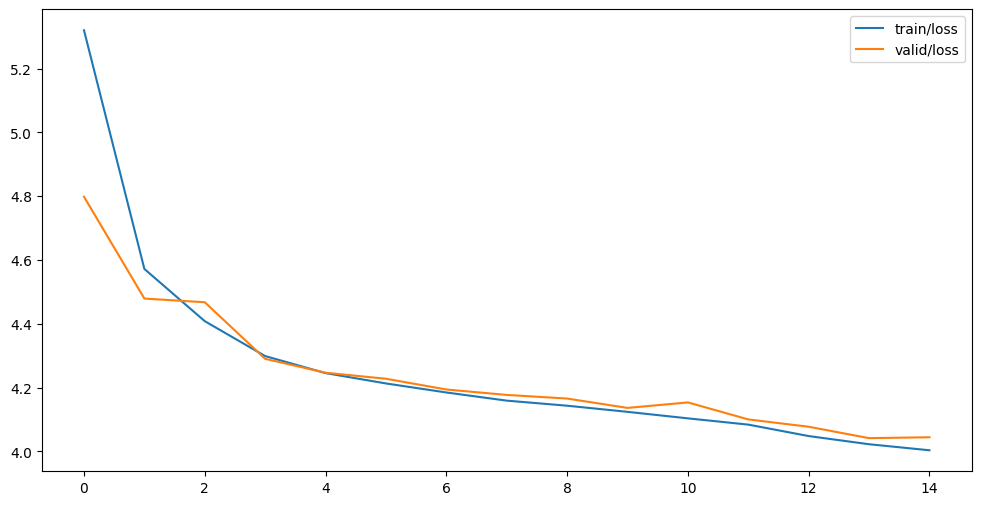

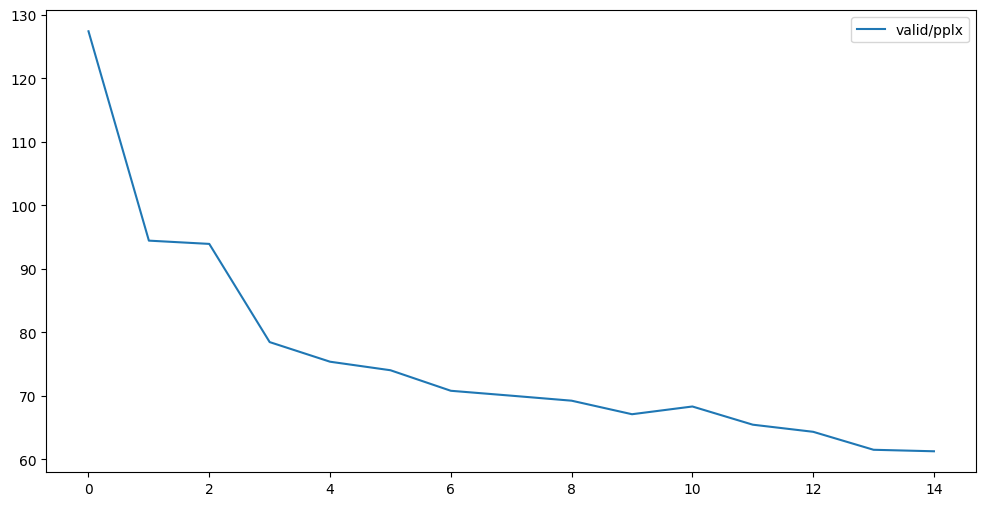

In [74]:
save_history(history, history_dir, save_graph=True)

you re big torch.Size([40, 4])


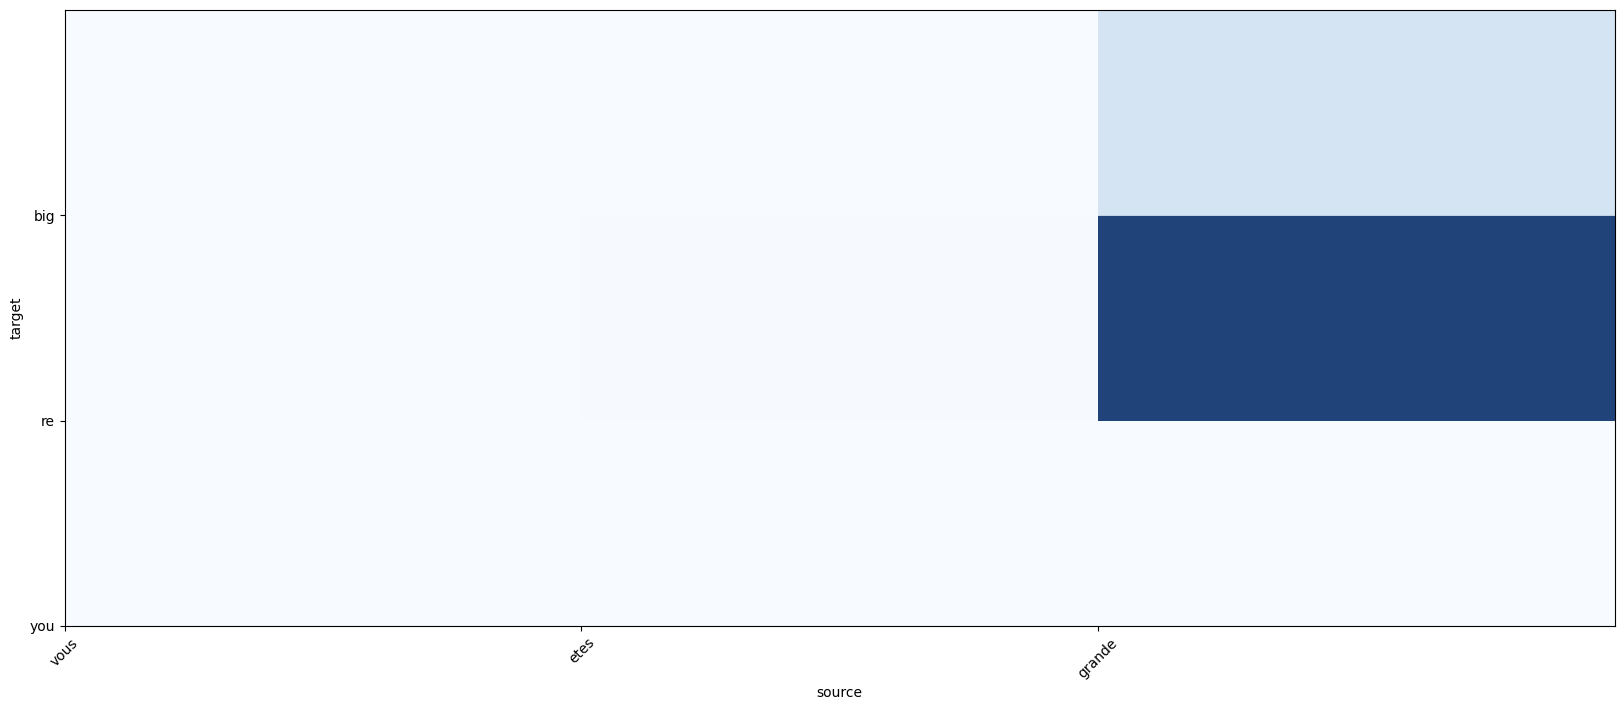

In [82]:
sentence = "vous etes grande"
hyp, attn = generate(
    model, sentence, src_tokenizer, tgt_tokenizer, cfg, method="greedy"
)
attn = attn.squeeze(0)
print(hyp[0], attn.shape)
plot_attention(attn.squeeze(0), sentence, hyp[0])

In [70]:
with open(f"{data_root}/dev.{cfg['src']}") as srcfile:
    sources = srcfile.readlines()

hypotheses = []
for source in sources:
    hyp, _ = generate(model, source, src_tokenizer, tgt_tokenizer, cfg, method="beam")
    hypotheses.append(hyp[0])

compute_metrics(hypotheses, sources)

{'bleu1': 0.044045571237802505,
 'bleu2': 0.0045280721969902515,
 'bleu3': 0.0,
 'bleu4': 0.0,
 'rougeL': 0.015775779262185097}